# This demo is going to realize the Dark Channel Prior Method
###  By Pion. C
###  Last edited time: 2022-11-14
#### Reference: 

#### Paper:

Dark Channel Prior: https://scholar.google.com/citations?view_op=view_citation&hl=en&user=DhtAFkwAAAAJ&citation_for_view=DhtAFkwAAAAJ:3fE2CSJIrl8C

Guided Image Filtering:https://kaiminghe.github.io/publications/eccv10guidedfilter.pdf

Blog article:
https://www.cnblogs.com/Imageshop/p/3281703.html

https://blog.csdn.net/sinat_36264666/article/details/77990790

https://blog.csdn.net/wsp_1138886114/article/details/84228939

## Import Libs

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Functions Part:

In [2]:
def get_dark_channel(img, k_size = 7):
    """
    img is the input image.
    k_size is the kernel size to set the center value as the minimum value in the kernel.
    
    returen Dark Channel.
    """
    rows, cols, channels = img.shape
    img_tmp = np.zeros((rows, cols, channels))
    img_dc = np.zeros((rows, cols))
    center_pos = int(k_size / 2.0)
    # Filter the min_value in a k_size kernel
    for ch in range (0, channels):
        for row in range (0, rows - k_size):
            for col in range (0, cols - k_size):
                min_value = img[row, col, ch]
                for k_row in range (0, k_size):
                    for k_col in range (0, k_size):
                        if img[row + k_row, col + k_col, ch] < min_value:
                            min_value = img[row + k_row, col + k_col, ch]
                img_tmp[row + center_pos, col + center_pos, ch] = min_value

    # Get the minimum value among RGB channels
    for row in range (0, rows):
        for col in range (0, cols):
            min_value = img_tmp[row, col, 0]
            if img[row, col, 1] < min_value:
                min_value = img_tmp[row, col, 1]
            if img[row, col, 2] < min_value:
                min_value = img_tmp[row, col, 2]
            img_dc[row, col] = min_value
            
    return img_dc

In [3]:
def get_atmospheric_light(img, img_dc):
    """
    img is the original image.
    img_dc is the Dark Channel.
    
    return the atmospheric light A.
    """
    lightest_list = [] # store in the format of [ {'position': (row, col), 'value': 255}, { , } ]
    original_pixels = []
    dc_tmp = img_dc.copy()
    lightest_num = int(0.001 * img_dc.size)
    
    rows, cols, channels = img.shape
    A_tmp = 0  # atmospheric light A: select the lightest pixel in the original image as the value of A
    
    while len(lightest_list) <= lightest_num:
        max_value = 0
        # find the max value in Dark Channel
        for row in range (0, rows):
            for col in range (0, cols):
                if dc_tmp[row, col] > max_value:
                    max_value = dc_tmp[row, col]
                    max_row, max_col = row, col
        dc_tmp[max_row, max_col] = 0

        # find the max intensity in original image
        for row in range (0, rows):
            if len(lightest_list) > lightest_num: # more than 0.1%
                break
            for col in range (0, cols):
                if len(lightest_list) > lightest_num: # more than 0.1%
                    break
                if img_dc[row, col] == max_value:
                    lightest_list.append({'position':(row, col), 'value':img_dc[row, col]})
                    original_pixels.append((img[row, col, 0], img[row, col, 1], img[row, col, 2]))
                    dc_tmp[row, col] = 0
                    # calculate the mean intensity of 3 channels in order to get A
                    r_value, g_value, b_value = int(img[row, col, 0]), int(img[row, col, 1]), int(img[row, col, 2])
                    mean_intensity = (r_value + g_value + b_value) / 3.0
                    if mean_intensity > A_tmp:
                        A_tmp = mean_intensity
                        A_value = img[row, col]
    
    A = np.zeros((rows, cols, channels))
    for row in range (0, rows):
        for col in range (0, cols):
            for ch in range (0, channels):
                A[row, col, ch] = A_value[ch]
    
    return A
                

In [4]:
# From: https://blog.csdn.net/wsp_1138886114/article/details/84228939
def guideFilter(p, i, r, e = 0.0001):
    """
    The function of this filter is smooth the image according to a guide image.
    p is the guide image.
    i is the original image.
    r is the window/kernel size.
    e is a backup Denominator, which is used to avoid the situation that the denominator become 0.
    
    return a guide filtered image q.
    """ 
    mean_I = cv2.boxFilter(i, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(i * i, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(i * p, cv2.CV_64F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p
    # 3
    a = cov_Ip / (var_I + e)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * i + mean_b
    return q

In [5]:
def get_transmission(img, A, omega = 0.95, k_size = 7):
    """
    img is the original image.
    A is the atmospheric light.
    omega is a constant parameter, it is used to keep tiny fog in the image. We use 0.95 by default.
    t_thres is the threshold of t. If t < t_thres, then t = t_thres. In order to avoid making the image too light.
    
    return the transmission t.
    """
    rows, cols, channels = img.shape
    
    # get img/A
    img_A = img / A
    # get min(min(img/A))
    img_A_dc = get_dark_channel(img_A, k_size)
    # guide filtering
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype('float64')
    img_A_dc = guideFilter(img_A_dc, img_grey , 225, 0.0001)
    # get t
    t = 1 - omega * img_A_dc
    
    return t

In [6]:
def remove_fog(img, t_thres = 0.1, omega = 0.95, k_size = 7):
    """
    img is the original image.
    A is the Atmosperic Light.
    t is the Transmission.
    t_thres is the threshold of t. If t < t_thres, then t = t_thres. In order to avoid making the image too light.
    
    return an image img_fogremoved whose fog has been removed.
    """
    rows, cols, channels = img.shape
    img_fogremoved = np.zeros((rows, cols, channels))
    
    # get dark_channel
    img_dc = get_dark_channel(img, k_size)
    # get A
    A = get_atmospheric_light(img, img_dc)
    # get t
    t = get_transmission(img, A, omega, k_size)
    # get the fog removed image
    for row in range(0, rows):
        for col in range(0, cols):
            for ch in range(0, channels):
                img_fogremoved[row, col, ch] = (img[row, col, ch] - A[row, col, ch]) \
                                             / (max(t[row, col], t_thres)) \
                                             + A[row, col, ch]
                if img_fogremoved[row, col, ch] < 0:
                    img_fogremoved[row, col, ch] = 0
                elif img_fogremoved[row, col, ch] > 255:
                    img_fogremoved[row, col, ch] = 255
                elif img_fogremoved[row, col, ch] >= 0 and img_fogremoved[row, col, ch] <= 255:
                    img_fogremoved[row, col, ch] = int(img_fogremoved[row, col, ch])

    return np.uint8(img_fogremoved)

### Read image and plot

(156, 210, 3)

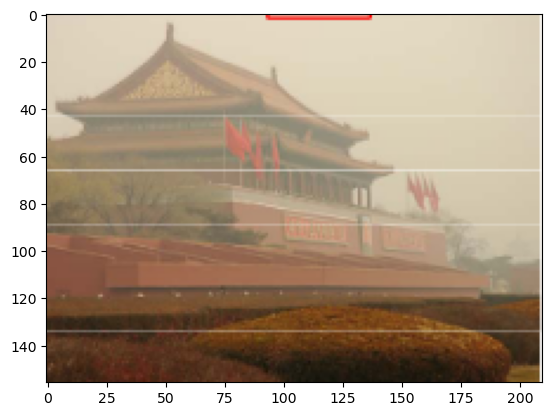

In [7]:
# img_path = "tiananmen.jpg"
img_path = "tiananmen.jpg"

img_origin = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))

img0 = img_origin.copy()
rows, cols, channels = img0.shape
img0.shape


### 1. Get the Dark Channel

In [8]:
img_dc0 = get_dark_channel(img0)

185.0


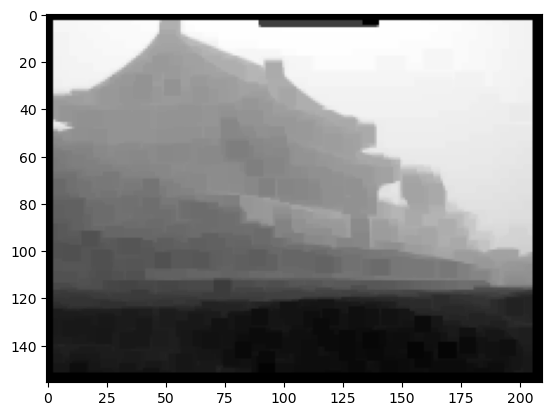

In [9]:
plt.imshow(img_dc0, cmap ='gray')
cv2.imwrite("darkchannel.jpg", img_dc0)
print(img_dc0[26,7])

### 2. Calculate Atmospheric Light -- A
Get the histogram of Dark Channel in descending order, and extract the 0.1% lightest pixels. Then, find the lightest pixel in the original image according to the corresponding position of extracted pixels.

In [10]:
A0 = get_atmospheric_light(img0, img_dc0)

### 3. Calculate Transmission -- t(x)
Normally, we choose omega = 0.95 to calculate the transmission of every pixel.

The function of Guide Filter is smooth the image according to a guide image.
The guideFilter part is from https://blog.csdn.net/wsp_1138886114/article/details/84228939

In [11]:
t0 = get_transmission(img0, A0)

True

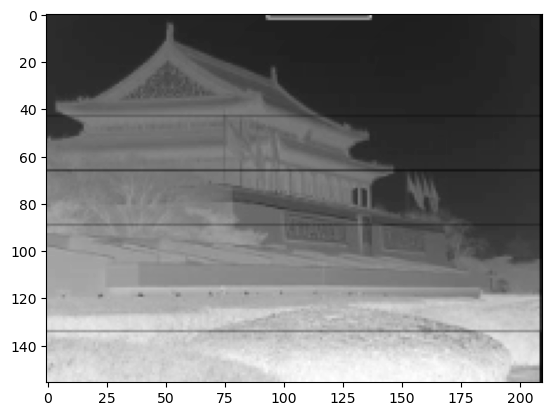

In [12]:
plt.imshow(t0 * 255, cmap = 'gray')
cv2.imwrite("transmission.jpg", t0*255)

### 4. Get the image without fog

In [13]:
fog_removed = remove_fog(img0)
cv2.imwrite("fog_removed.jpg", fog_removed)

True

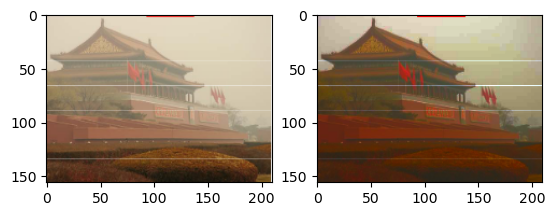

In [23]:
plt.figure(1)
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(fog_removed, cv2.COLOR_BGR2RGB))

### 5. Use this method process submarine images

In [15]:
starfish_path = "0-62.jpg"
starfish = cv2.imread(starfish_path)

starfish0 = starfish.copy()

#### Let k_size = 3

True

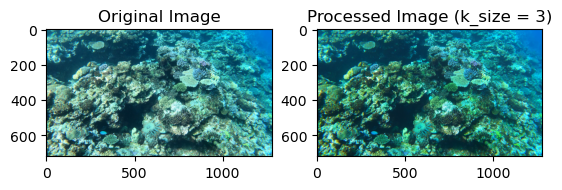

In [16]:
size = 3
starfish_ksize3 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize3, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize3)

#### Let k_size = 5

True

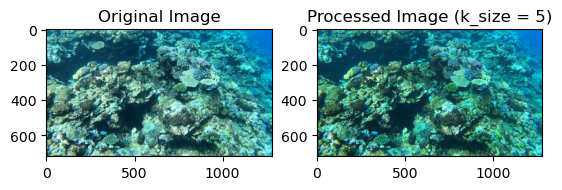

In [17]:
size = 5
starfish_ksize5 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize5, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize5)

#### Let k_size = 7

True

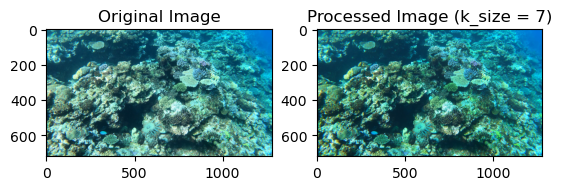

In [18]:
size = 7
starfish_ksize7 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize7, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize7)

#### Let k_size = 9

True

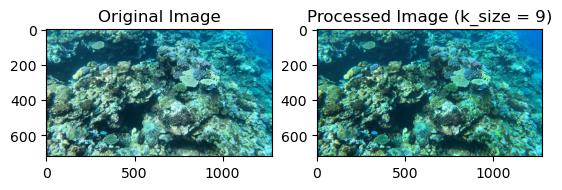

In [19]:
size = 9
starfish_ksize9 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize9, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize9)

#### Let k_size = 11

True

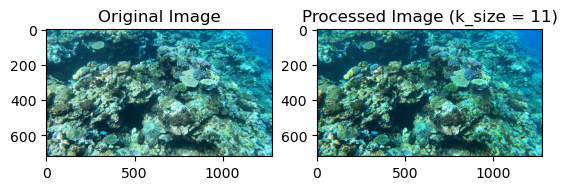

In [20]:
size = 11
starfish_ksize11 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize11, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize11)

#### Let k_size = 13

True

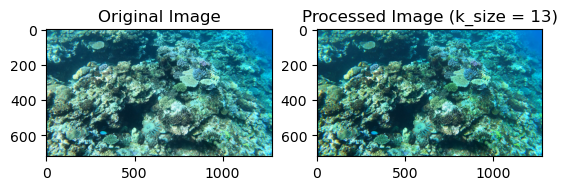

In [21]:
size = 13
starfish_ksize13 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize13, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize13)

#### Let k_size = 15

True

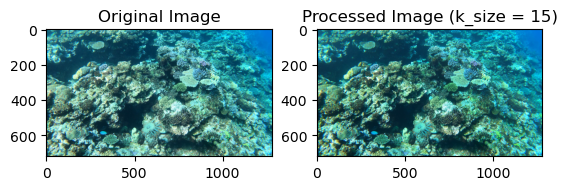

In [22]:
size = 15
starfish_ksize15 = remove_fog(starfish0, k_size = size)

plt.figure(1)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(starfish, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Processed Image (k_size = {})'.format(size))
plt.imshow(cv2.cvtColor(starfish_ksize15, cv2.COLOR_BGR2RGB))
cv2.imwrite("starfish_ksize{}.jpg".format(size), starfish_ksize15)

### 6. Conclusion
From above outputs, when k_size = 3, the processed image has the best visual performence with the fastest speed.

In [29]:
img_list = [starfish, starfish_ksize3, starfish_ksize5, starfish_ksize7, starfish_ksize9, starfish_ksize11, starfish_ksize13, starfish_ksize15]
name_list = ['Original Image', 'k_size = 3', 'k_size = 5', 'k_size = 7', 'k_size = 9', 'k_size = 11', 'k_size = 13', 'k_size = 15']

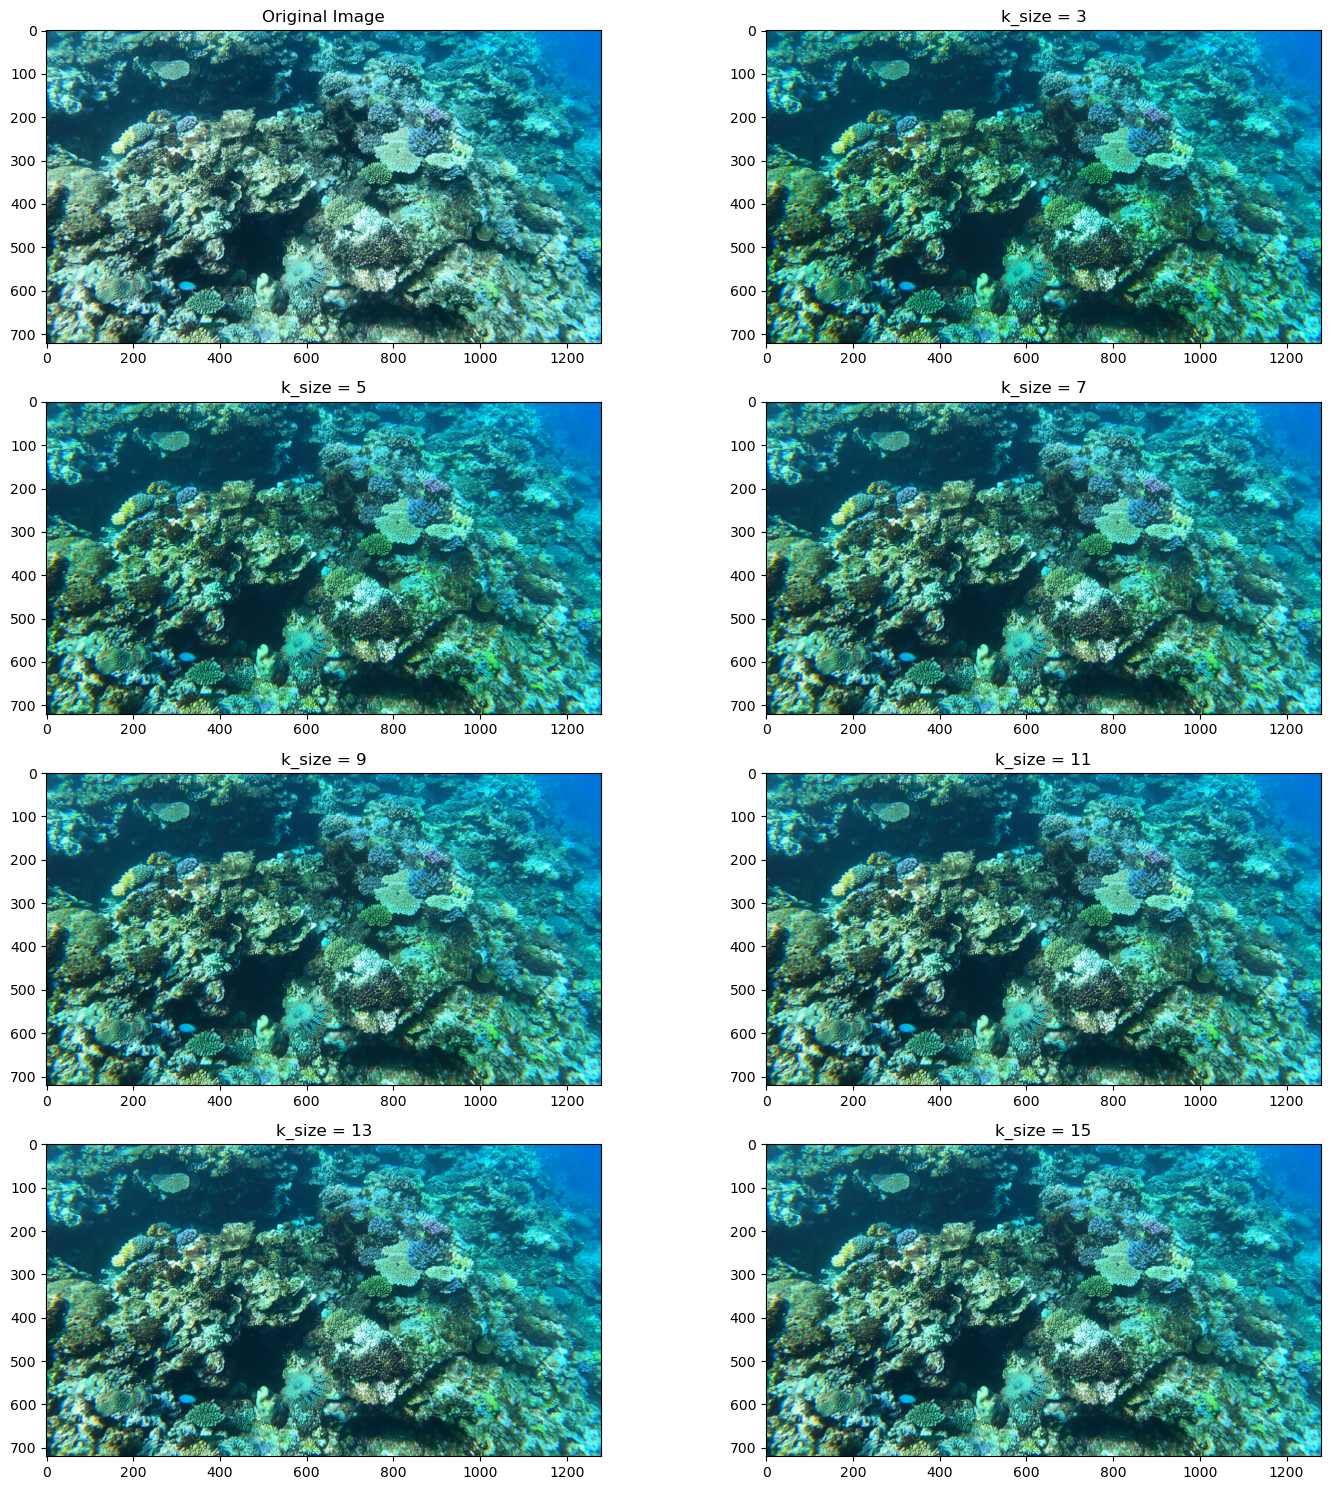

In [56]:
fig = plt.figure(figsize=(15, 15), layout='tight')
for n in range(0, len(img_list)):
    fig.add_subplot(4, 2, n+1)
    plt.title(name_list[n])
    plt.imshow(cv2.cvtColor(img_list[n], cv2.COLOR_BGR2RGB))